# Project: Investigate soccer matches, players, and teams from serveral European countries from 2008 to 2016. 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> I will be analyzing the European soccer dataset.  This dataset pulls together information from multiple websits into one dataset that contains information on 25,000+ matches, 10,000+ players, 11 European Contries with their lead championship, season 2008 to 2016, players and teams' attributes, team line ups, betting odds and detailed match events.

>Is one league more competitive than the others? Got the idea from https://5addedminutes.com/2011/05/25/measuring-the-premier-league%E2%80%99s-competitiveness/

>Does one league have more parity then the others?

> What teams improved the most over the time period? Which players had the most penalties? What team attributes lead to the most victories?


In [120]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> Gather data for each league.

### General Properties

In [121]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

#found connect details on https://www.kaggle.com/hugomathien/soccer
#connect to the soccer database
database = './database.sqlite'
conn = sqlite3.connect(database)

#query for table names
query = "SELECT name FROM sqlite_master WHERE type='table' order by 1;"
pd.read_sql(query,conn)

,name
0,Country
1,League
2,Match
3,Player
4,Player_Attributes
5,Team
6,Team_Attributes
7,sqlite_sequence


In [122]:
#Obtain Country ID
query="SELECT * FROM Country;"
df_league = pd.read_sql(query,conn)
df_league.head()

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [123]:
#List of teams
query="select * from Team;"
df_teams = pd.read_sql(query,conn)
df_teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [124]:
# Match data
query="SELECT * FROM Match;"
df_matches = pd.read_sql(query,conn)
df_matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


### Data Cleaning  
>Collect data and add additional data that I will be using to research my questions.  I choose to leave the data as is as I only needed a subset of the data and the subset did not include any nulls or any data the needed to be removed or replaced.

In [125]:
#Check for duplicates.
sum(df_matches.duplicated())

0

In [126]:
# I did not remove any nulls or replace any nulls as the data I needed did not include any nulls.
df_matches.isnull().any(axis=1).sum()

24217

In [127]:
df_matches.shape

(25979, 115)

In [128]:
# Select the base data needed to research the dataset.
query="SELECT c.name as country, m.season, t.team_long_name as home_team, t1.team_long_name as away_team, m.home_team_goal, m.away_team_goal FROM Match m JOIN Country c ON c.id = m.league_id JOIN Team t ON t.team_api_id = m.home_team_api_id JOIN Team t1 ON t1.team_api_id = m.away_team_api_id;"
df_match_data = pd.read_sql(query,conn)
df_match_data.head()

,country,season,home_team,away_team,home_team_goal,away_team_goal
0,Belgium,2008/2009,KRC Genk,Beerschot AC,1,1
1,Belgium,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0
2,Belgium,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3
3,Belgium,2008/2009,KAA Gent,RAEC Mons,5,0
4,Belgium,2008/2009,FCV Dender EH,Standard de Liège,1,3


In [129]:
df_match_data.isnull().any(axis=1).sum()

0

In [130]:
#Add new columns and assign points per match for each team
# 3 for win
# 1 for tie
# 0 for loss
#https://stackoverflow.com/questions/21733893/pandas-dataframe-add-a-field-based-on-multiple-if-statements
df_match_data['home_team_pts'] = 0
df_match_data['away_team_pts'] = 0    
df_match_data.loc[df_match_data['home_team_goal'] > df_match_data['away_team_goal'],'home_team_pts'] = 3
df_match_data.loc[df_match_data['home_team_goal'] < df_match_data['away_team_goal'],'away_team_pts'] = 3
df_match_data.loc[df_match_data['home_team_goal'] == df_match_data['away_team_goal'],'home_team_pts'] = 1
df_match_data.loc[df_match_data['home_team_goal'] == df_match_data['away_team_goal'],'away_team_pts'] = 1
df_match_data.head()

,country,season,home_team,away_team,home_team_goal,away_team_goal,home_team_pts,away_team_pts
0,Belgium,2008/2009,KRC Genk,Beerschot AC,1,1,1,1
1,Belgium,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0,1,1
2,Belgium,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3,0,3
3,Belgium,2008/2009,KAA Gent,RAEC Mons,5,0,3,0
4,Belgium,2008/2009,FCV Dender EH,Standard de Liège,1,3,0,3


In [131]:
#Add new columns Wins, losses and Draws
df_match_data['home_win'] = 0
df_match_data['away_win'] = 0    
df_match_data['home_loss'] = 0
df_match_data['away_loss'] = 0  
df_match_data['draw'] = 0   
df_match_data.loc[df_match_data['home_team_goal'] > df_match_data['away_team_goal'],'home_win'] = 1
df_match_data.loc[df_match_data['home_team_goal'] > df_match_data['away_team_goal'],'away_loss'] = 1
df_match_data.loc[df_match_data['home_team_goal'] < df_match_data['away_team_goal'],'away_win'] = 1
df_match_data.loc[df_match_data['home_team_goal'] < df_match_data['away_team_goal'],'home_loss'] = 1
df_match_data.loc[df_match_data['home_team_goal'] == df_match_data['away_team_goal'],'draw'] = 1
df_match_data.head()

,country,season,home_team,away_team,home_team_goal,away_team_goal,home_team_pts,away_team_pts,home_win,away_win,home_loss,away_loss,draw
0,Belgium,2008/2009,KRC Genk,Beerschot AC,1,1,1,1,0,0,0,0,1
1,Belgium,2008/2009,SV Zulte-Waregem,Sporting Lokeren,0,0,1,1,0,0,0,0,1
2,Belgium,2008/2009,KSV Cercle Brugge,RSC Anderlecht,0,3,0,3,0,1,1,0,0
3,Belgium,2008/2009,KAA Gent,RAEC Mons,5,0,3,0,1,0,0,1,0
4,Belgium,2008/2009,FCV Dender EH,Standard de Liège,1,3,0,3,0,1,1,0,0


<a id='eda'></a>
## Exploratory Data Analysis

### Are leagues becoming more or less competitive?

>  I will compare the average goals per season of the top five teams with the average goals per season of the bottom five teams.  If the difference of average goals per season grow over time then the league is becomeing less competitive.  If the differences in averages decrease over time then the leagues is becoming more competitive.  I would expect this data would give a good overall view of each leaque and its overall competitiveness.


In [132]:
#Calculate season points per team to determine the top five and bottom five teams.
df_team_pts_by_season = pd.DataFrame(columns=['total_pts'])
df_team_pts_by_season['total_pts'] = (df_match_data.groupby(['country','season','home_team'])['home_team_pts'].sum() +  df_match_data.groupby(['country','season','away_team'])['away_team_pts'].sum())
df_team_pts_by_season.reset_index(inplace=True)

In [133]:
#Obtain a list of the top five and bottom five teams for each season by league.
df_top_five = df_team_pts_by_season.sort_values(['country','season','total_pts'], ascending=False).groupby(['country','season']).head(5)
df_bottom_five = df_team_pts_by_season.sort_values(['country','season','total_pts'], ascending=False).groupby(['country','season']).tail(5)
df_top_five = df_top_five.rename(columns = {'home_team':'team'})
df_bottom_five=df_bottom_five.rename(columns = {'home_team':'team'})

In [134]:
df_top_five.head()

,country,season,team,total_pts
1469,Switzerland,2015/2016,FC Basel,83
1468,Switzerland,2015/2016,BSC Young Boys,69
1470,Switzerland,2015/2016,FC Luzern,54
1476,Switzerland,2015/2016,Grasshopper Club Zürich,53
1471,Switzerland,2015/2016,FC Sion,50


In [135]:
df_bottom_five.head()

,country,season,team,total_pts
1473,Switzerland,2015/2016,FC Thun,41
1472,Switzerland,2015/2016,FC St. Gallen,38
1474,Switzerland,2015/2016,FC Vaduz,36
1477,Switzerland,2015/2016,Lugano,35
1475,Switzerland,2015/2016,FC Zürich,34


In [136]:
#Calculate the number of games per team per leaque per season, used to calculate average goals per game per team
df_team_games_by_season = pd.DataFrame(columns=['total_games'])
df_team_games_by_season['total_games'] = df_match_data.groupby(['country','season','home_team'])['home_team'].count() +  df_match_data.groupby(['country','season','away_team'])['away_team'].count()
df_team_games_by_season.reset_index(inplace=True)
df_team_games_by_season=df_team_games_by_season.rename(columns = {'home_team':'team'})
df_team_games_by_season.head()

,country,season,team,total_games
0,Belgium,2008/2009,Beerschot AC,34
1,Belgium,2008/2009,Club Brugge KV,34
2,Belgium,2008/2009,FCV Dender EH,34
3,Belgium,2008/2009,KAA Gent,34
4,Belgium,2008/2009,KRC Genk,34


In [137]:
#Calculate total goals per season per team per league, used to calculate average goals per game per team.
df_team_goals_by_season = pd.DataFrame(columns=['total_goals'])
df_team_goals_by_season['total_goals'] = df_match_data.groupby(['country','season','home_team'])['home_team_goal'].sum() +  df_match_data.groupby(['country','season','away_team'])['away_team_goal'].sum()
df_team_goals_by_season.reset_index(inplace=True)
df_team_goals_by_season=df_team_goals_by_season.rename(columns = {'home_team':'team'})
df_team_goals_by_season.head()

,country,season,team,total_goals
0,Belgium,2008/2009,Beerschot AC,44
1,Belgium,2008/2009,Club Brugge KV,59
2,Belgium,2008/2009,FCV Dender EH,44
3,Belgium,2008/2009,KAA Gent,67
4,Belgium,2008/2009,KRC Genk,48


In [138]:
#merge total_games data with the total_goals data
merged_data = pd.merge(df_team_goals_by_season, df_team_games_by_season, on=['country','season','team'])
#calculate the average number of goals per game
merged_data['average_goals_per_game']=merged_data['total_goals']/merged_data['total_games']
merged_data.head()

,country,season,team,total_goals,total_games,average_goals_per_game
0,Belgium,2008/2009,Beerschot AC,44,34,1.294118
1,Belgium,2008/2009,Club Brugge KV,59,34,1.735294
2,Belgium,2008/2009,FCV Dender EH,44,34,1.294118
3,Belgium,2008/2009,KAA Gent,67,34,1.970588
4,Belgium,2008/2009,KRC Genk,48,34,1.411765


In [139]:
#meage average number of goals per game with the top five teams for each league per season.
merged_data_bottom_five = pd.merge(df_bottom_five, merged_data, on=['country','season','team'])
merged_data_bottom_five.head()

,country,season,team,total_pts,total_goals,total_games,average_goals_per_game
0,Switzerland,2015/2016,FC Thun,41,45,36,1.250000
1,Switzerland,2015/2016,FC St. Gallen,38,41,36,1.138889
2,Switzerland,2015/2016,FC Vaduz,36,44,36,1.222222
3,Switzerland,2015/2016,Lugano,35,46,36,1.277778
4,Switzerland,2015/2016,FC Zürich,34,48,36,1.333333


In [140]:
#merge average number of goals per game with the bottom five teams for each league per season.
merged_data_top_five = pd.merge(df_top_five, merged_data, on=['country','season','team'])
merged_data_top_five.head()

,country,season,team,total_pts,total_goals,total_games,average_goals_per_game
0,Switzerland,2015/2016,FC Basel,83,88,36,2.444444
1,Switzerland,2015/2016,BSC Young Boys,69,78,36,2.166667
2,Switzerland,2015/2016,FC Luzern,54,59,36,1.638889
3,Switzerland,2015/2016,Grasshopper Club Zürich,53,65,36,1.805556
4,Switzerland,2015/2016,FC Sion,50,52,36,1.444444


In [141]:
#group average goals by league and season for top five teams per leaque each season
top_five_ave_goals_by_league = pd.DataFrame(columns=['ave_goals'])
top_five_ave_goals_by_league['ave_goals'] = merged_data_top_five.groupby(['country','season'])['average_goals_per_game'].mean()
top_five_ave_goals_by_league.reset_index(inplace=True)
top_five_ave_goals_by_league.head(10)

,country,season,ave_goals
0,Belgium,2008/2009,1.894118
1,Belgium,2009/2010,1.692857
2,Belgium,2010/2011,1.893333
3,Belgium,2011/2012,1.853333
4,Belgium,2012/2013,2.000000
5,Belgium,2013/2014,1.250000
6,Belgium,2014/2015,1.833333
7,Belgium,2015/2016,1.786667
8,England,2008/2009,1.768421
9,England,2009/2010,2.168421


In [142]:
#group average goals by league and season for bottom five teams per leaque each season
bottom_five_ave_goals_by_league = pd.DataFrame(columns=['ave_goals'])
bottom_five_ave_goals_by_league['ave_goals'] = merged_data_bottom_five.groupby(['country','season'])['average_goals_per_game'].mean()
bottom_five_ave_goals_by_league.reset_index(inplace=True)

In [143]:
bottom_five_ave_goals_by_league.head()

,country,season,ave_goals
0,Belgium,2008/2009,1.058824
1,Belgium,2009/2010,1.000000
2,Belgium,2010/2011,0.786667
3,Belgium,2011/2012,1.033333
4,Belgium,2012/2013,0.980000


In [144]:
top_five_ave_goals_by_league.head()

,country,season,ave_goals
0,Belgium,2008/2009,1.894118
1,Belgium,2009/2010,1.692857
2,Belgium,2010/2011,1.893333
3,Belgium,2011/2012,1.853333
4,Belgium,2012/2013,2.000000


In [145]:
#split dataframes by league for plotting
split_top = np.array_split(top_five_ave_goals_by_league,11)
split_bottom = np.array_split(bottom_five_ave_goals_by_league,11)

In [146]:
split_top[0].head(8)

,country,season,ave_goals
0,Belgium,2008/2009,1.894118
1,Belgium,2009/2010,1.692857
2,Belgium,2010/2011,1.893333
3,Belgium,2011/2012,1.853333
4,Belgium,2012/2013,2.000000
5,Belgium,2013/2014,1.250000
6,Belgium,2014/2015,1.833333
7,Belgium,2015/2016,1.786667


In [147]:
split_bottom[0].head(8)

,country,season,ave_goals
0,Belgium,2008/2009,1.058824
1,Belgium,2009/2010,1.000000
2,Belgium,2010/2011,0.786667
3,Belgium,2011/2012,1.033333
4,Belgium,2012/2013,0.980000
5,Belgium,2013/2014,1.250000
6,Belgium,2014/2015,1.026667
7,Belgium,2015/2016,1.226667


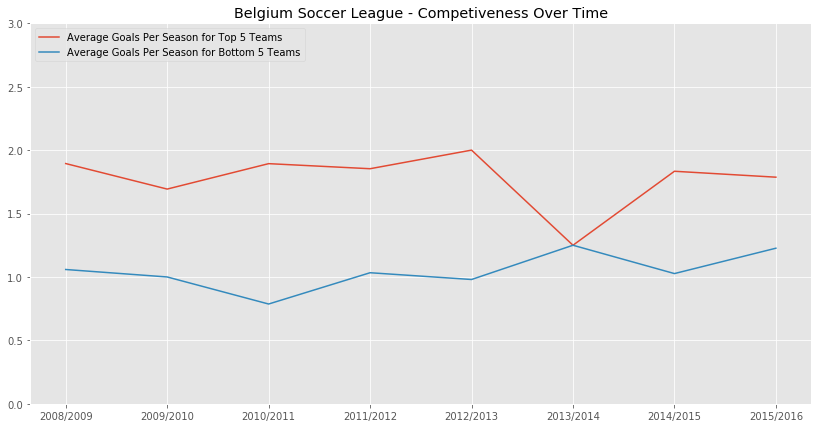

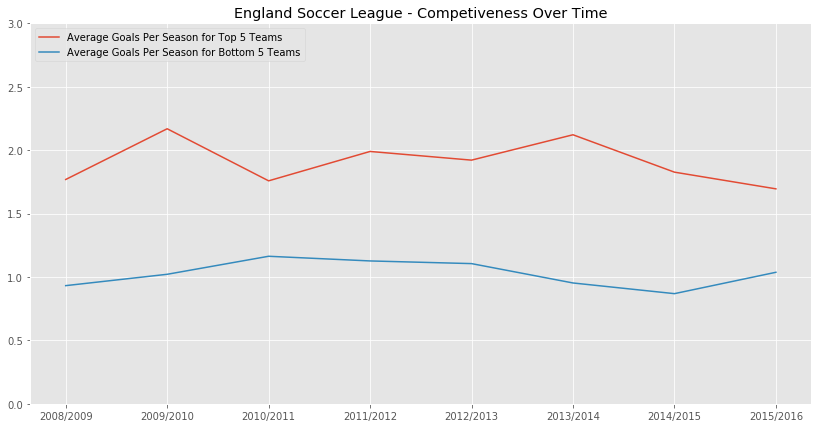

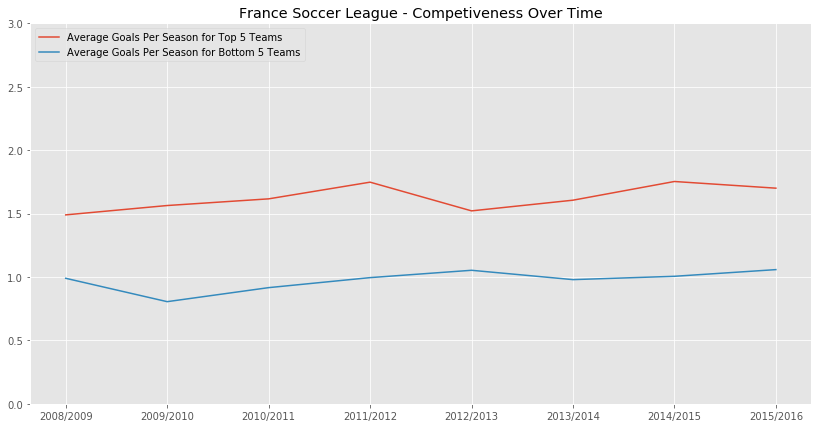

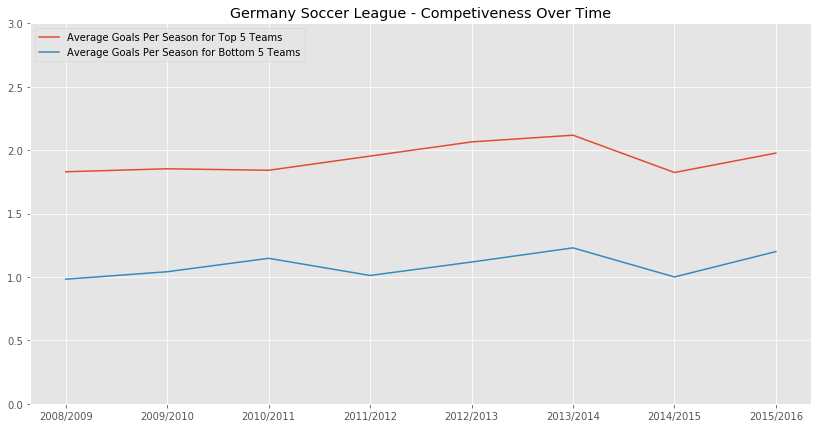

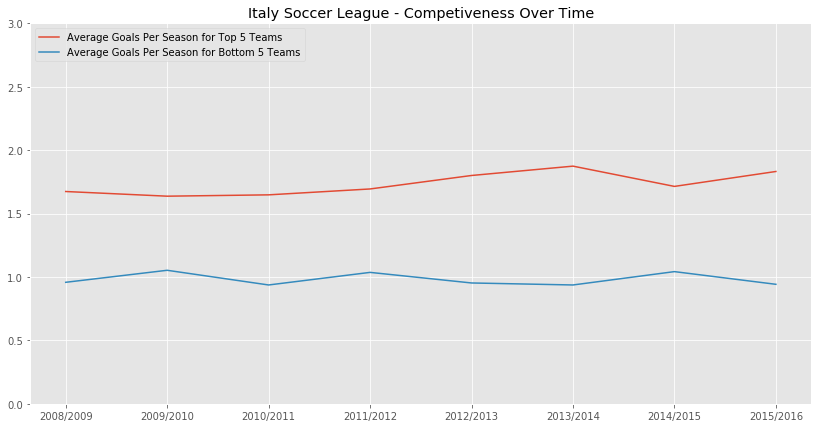

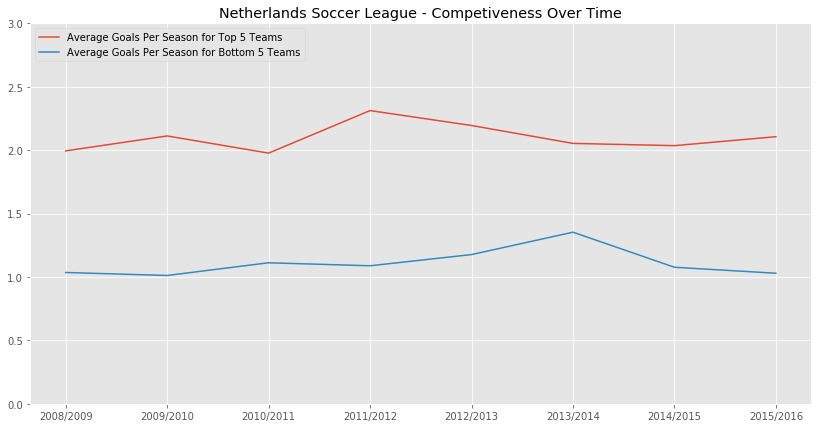

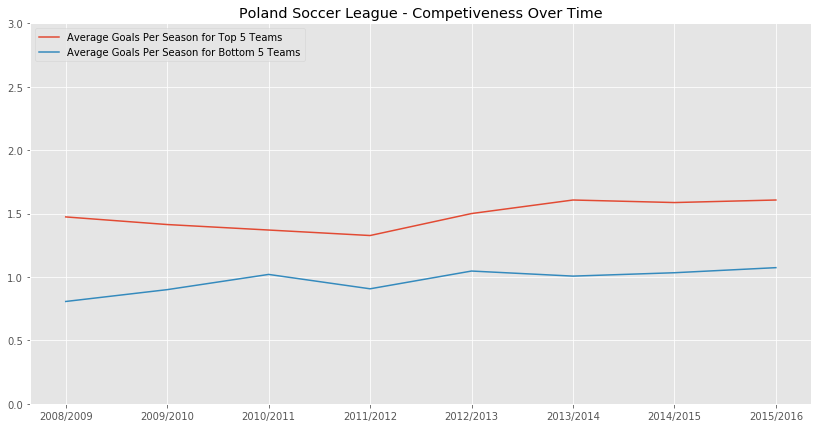

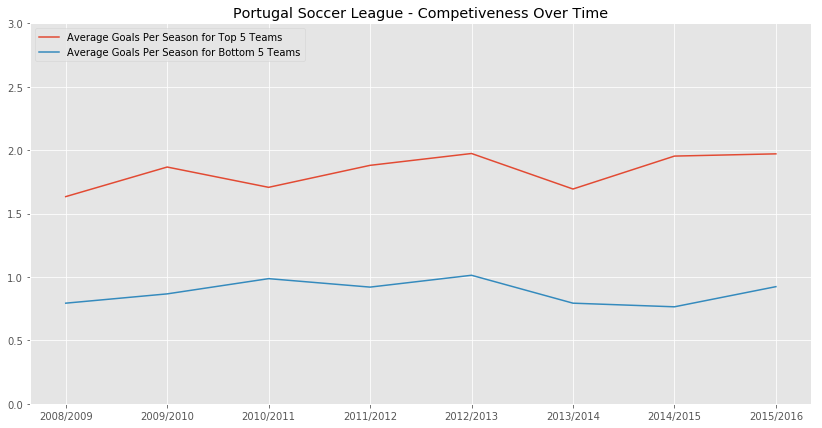

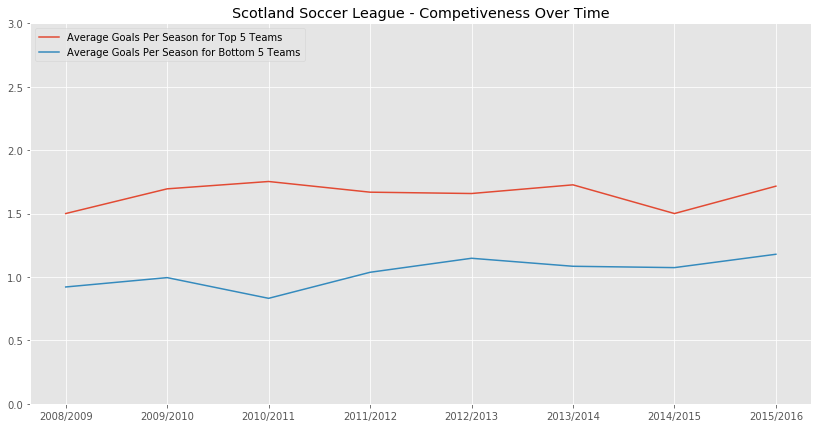

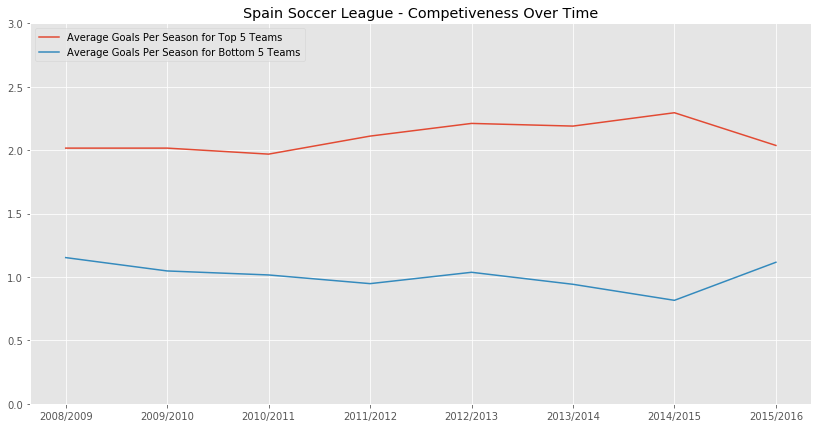

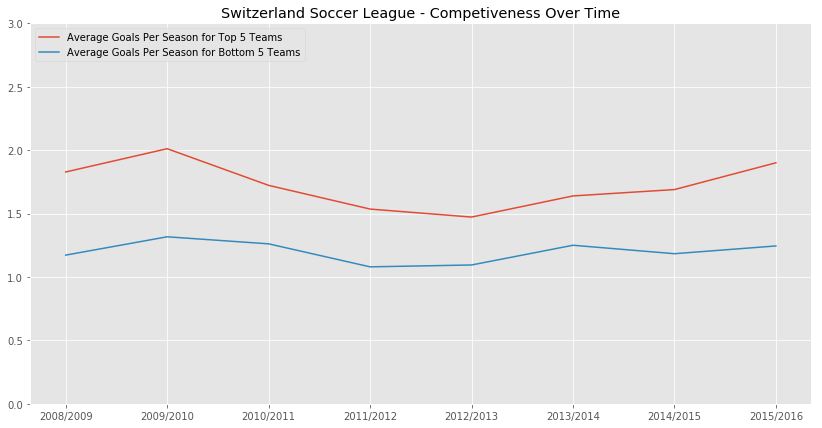

In [148]:
#plot each league's competitiveness over time.
def plot_competitiveness(country,subDataFrame):
    plt.style.use('ggplot')
    fig = plt.figure()
    fig.set_size_inches(14, 7)
    ax = plt.subplot(111)
    for frame in [split_top[subDataFrame], split_bottom[subDataFrame]]:
        plt.plot(frame['season'],frame['ave_goals'])

    plt.ylim(0,3)
    ax.set_title(country + ' Soccer League - Competiveness Over Time')
    ax.legend(["Average Goals Per Season for Top 5 Teams","Average Goals Per Season for Bottom 5 Teams"],loc='upper left')
    plt.show()

plot_competitiveness('Belgium',0)
plot_competitiveness('England',1)
plot_competitiveness('France',2)
plot_competitiveness('Germany',3)
plot_competitiveness('Italy',4)
plot_competitiveness('Netherlands',5)
plot_competitiveness('Poland',6)
plot_competitiveness('Portugal',7)
plot_competitiveness('Scotland',8)
plot_competitiveness('Spain',9)
plot_competitiveness('Switzerland',10)

> The competitiveness of each leaque was stable over the years with a few season changing to more or less competitive.  The most competitive leagues based on this statistic which may not be enough to conclude the most competitive league, would be France, Netherlands and Spain.

>  What this fails to conclude is the quality of each leaque. What was the reason for the decrease or increase in scoring by the top or bottom 5 teams?  In some cases scoring for the whole leaque decreased or increased. What would be the reason for the overall average goals per game increase or decrease?  Is it because of the quality of the league or the qaulity of the players?  Did players transfer to other leagues?


## Which league has more parity?

> This question should provide detail into each leagues parity from top to bottom.  Even though the competition seems to be stable over the years, which teams are the top teams and do the top teams stay on top from year to year?

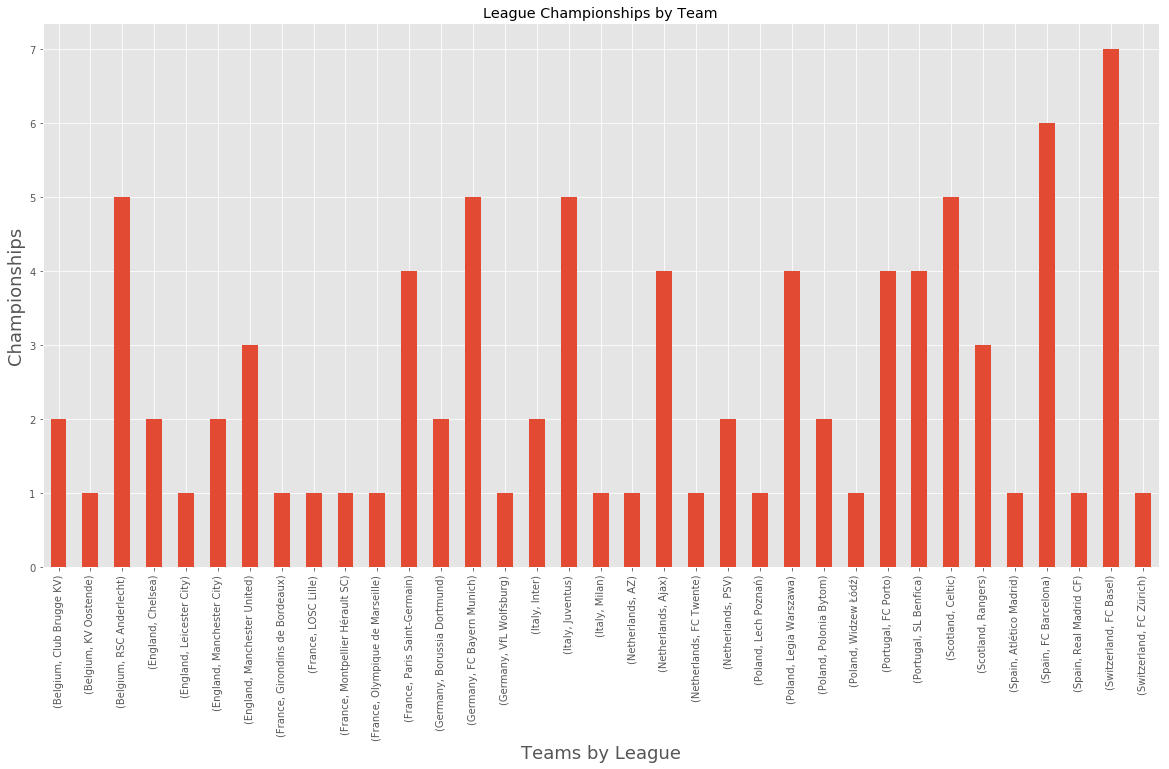

In [149]:
#Champions for each leaque over time.
df_season_champ = df_team_pts_by_season.sort_values(['country','season','total_pts'], ascending=False).groupby(['country','season']).head(1)
df_season_champ = df_season_champ.rename(columns = {'home_team':'team'})
df_season_champ.groupby(['country','team'])['team'].count().plot(kind='bar',figsize=(20,10));
df_season_champ.groupby(['country','team'])['team'].count().plot(kind='bar',figsize=(20,10),title='League Championships by Team');
plt.xlabel('Teams by League', fontsize=18)
plt.ylabel('Championships',fontsize=18);

As far as championships per league there is very little parity between top and bottom teams.  In most cases each league has at least one dominant team over the 8 year spand of the dataset.  There are some cases of an outlier team wining the championship but for the most part each league is dominated by 2 or 3 teams.  Again this does not reflect the quality of each league.

The following information and visualization should provide more details into the partiy between leagues.  Are the top five teams each year changing or is there some turn over at the top?

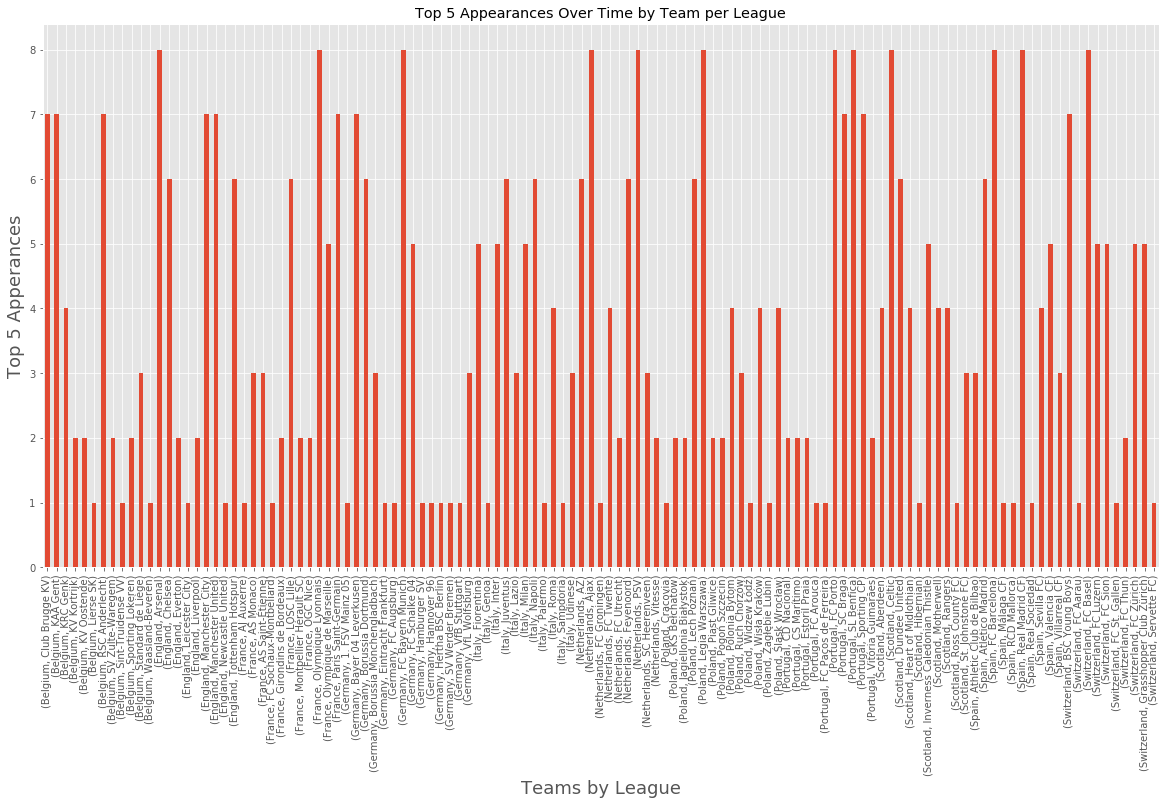

In [150]:
#Top five teams per season
df_top_teams = df_team_pts_by_season.sort_values(['country','season','total_pts'], ascending=False).groupby(['country','season']).head(5)
df_top_teams = df_top_teams.rename(columns = {'home_team':'team'})
df_top_teams.groupby(['country','team'])['team'].count().plot(kind='bar',figsize=(20,10),title='Top 5 Appearances Over Time by Team per League');
plt.xlabel('Teams by League', fontsize=18)
plt.ylabel('Top 5 Apperances',fontsize=18);

There does seem to be parity in the top 5 each year per league but this parity is not resulting into championships for other teams.  There are other variables that are not being reflected as to why each league is dominated by a few teams.  Player and team attributes, injuries, financial support also play a big factor in league success.

## What team attributes lead to the most championships?

> Looking only at the team that won the most championships with in each league determine what attributes contribute the most to winning a championship.  Should championships teams across leagues have similiar attributes?

In [151]:
#List of teams
query="select t.team_long_name, ta.* FROM team_attributes ta JOIN Team t on t.team_api_id = ta.team_api_id WHERE team_long_name in ('RSC Anderlecht','Manchester United','Paris Saint-Germain','FC Bayern Munich','Juventus','Ajax','Legia Warszawa','FC Porto','Celtic','FC Barcelona','FC Basel');"
df_team_att = pd.read_sql(query,conn)
df_team_att.head()

,team_long_name,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,Ajax,34,245,8593,2010-02-22 00:00:00,30,Slow,NaN,Little,30,...,70,Lots,Organised,30,Deep,30,Contain,30,Narrow,Cover
1,Ajax,35,245,8593,2011-02-22 00:00:00,40,Balanced,NaN,Little,38,...,67,Lots,Organised,65,Medium,57,Press,63,Normal,Cover
2,Ajax,36,245,8593,2012-02-22 00:00:00,31,Slow,NaN,Little,33,...,46,Normal,Free Form,68,High,65,Press,60,Normal,Cover
3,Ajax,37,245,8593,2013-09-20 00:00:00,35,Balanced,NaN,Little,33,...,46,Normal,Free Form,68,High,65,Press,50,Normal,Cover
4,Ajax,38,245,8593,2014-09-19 00:00:00,40,Balanced,40.0,Normal,30,...,39,Normal,Free Form,64,Medium,53,Press,64,Normal,Cover


In [152]:
df_team_att.isnull().any(axis=1).sum()

44

In [153]:
#replace nulls with the mean for each team for buildUpPlayDribbling
def nulls_to_mean (team_name):
    df_team_att.loc[(df_team_att.buildUpPlayDribbling.isnull()) & (df_team_att.team_long_name == team_name), 'buildUpPlayDribbling'] = df_team_att[df_team_att['team_long_name'] == team_name]['buildUpPlayDribbling'].mean()

nulls_to_mean('RSC Anderlecht')
nulls_to_mean('Manchester United')
nulls_to_mean('Paris Saint-Germain')
nulls_to_mean('FC Bayern Munich')                                                                
nulls_to_mean('Juventus')                                                                   
nulls_to_mean('Ajax')
nulls_to_mean('Legia Warszawa')
nulls_to_mean('FC Porto')                                                                   
nulls_to_mean('Celtic')
nulls_to_mean('FC Barcelona')
nulls_to_mean('FC Basel')

In [154]:
df_team_att.isnull().any(axis=1).sum()
#df_team_att['buildUpPlayDribbling'].isnull()

0

In [155]:
df_team_att.head()

,team_long_name,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,Ajax,34,245,8593,2010-02-22 00:00:00,30,Slow,41.5,Little,30,...,70,Lots,Organised,30,Deep,30,Contain,30,Narrow,Cover
1,Ajax,35,245,8593,2011-02-22 00:00:00,40,Balanced,41.5,Little,38,...,67,Lots,Organised,65,Medium,57,Press,63,Normal,Cover
2,Ajax,36,245,8593,2012-02-22 00:00:00,31,Slow,41.5,Little,33,...,46,Normal,Free Form,68,High,65,Press,60,Normal,Cover
3,Ajax,37,245,8593,2013-09-20 00:00:00,35,Balanced,41.5,Little,33,...,46,Normal,Free Form,68,High,65,Press,50,Normal,Cover
4,Ajax,38,245,8593,2014-09-19 00:00:00,40,Balanced,40.0,Normal,30,...,39,Normal,Free Form,64,Medium,53,Press,64,Normal,Cover


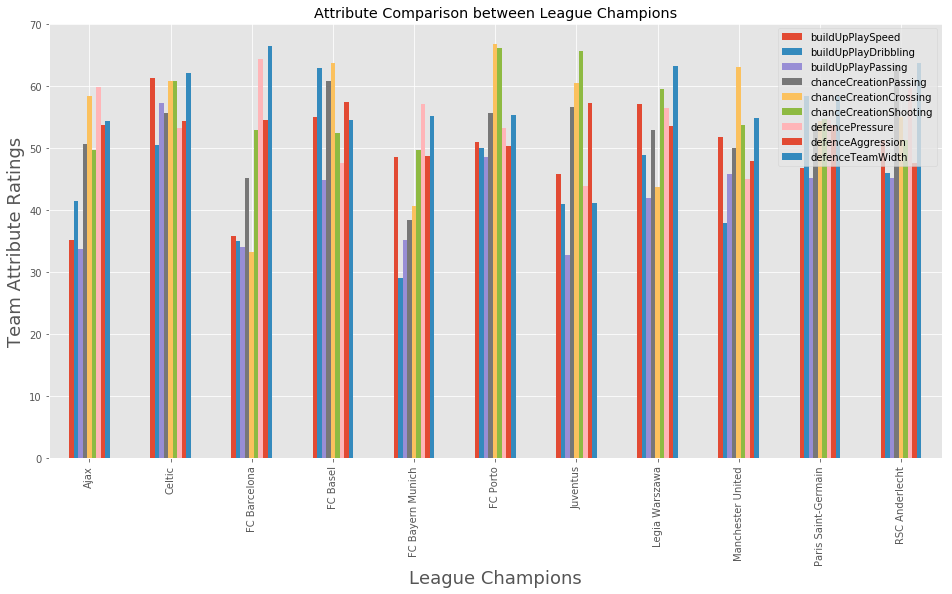

In [156]:
df_team_compare_att = df_team_att.groupby(['team_long_name']).mean()
df_team_compare_att.drop(['id', 'team_fifa_api_id', 'team_api_id'], axis=1, inplace=True)
df_team_compare_att.plot(kind='bar',figsize=(16,8),title='Attribute Comparison between League Champions')
plt.xlabel('League Champions', fontsize=18)
plt.ylabel('Team Attribute Ratings',fontsize=18);

The team with the most championships is FC Basel from the Switzerland League.  FC Basel's profile looks different than the profiles from other leaques.  This data seems to show that attributes from one league champion will not gaurantee success in another league.  It also seems to show that there are is no one formula of attributes that would win championships.  The one missing variable is the quality of each league compared to the other leagues.  How can we measure quality of each league?

<a id='conclusions'></a>
## Conclusions

The competitiveness of each leaque was stable over the years with a few season changing to more competitive or less competitive.  The most competitive leagues based on this statistic which may not be enough to conclude the most competitive league, would be France, Netherlands and Spain.

However, I was not able to compare teams across leagues and there did not seem to be a way to get a real sense of the quality of each league.  Each league's champion had different attributes which leads me to believe that each leaque's quality is different.  

As far as parity for each league, there does not seem to much.  Yes, each league has some parity in the top five teams from year to year but the champions of each league comes from just a few teams within the league.  Possibly the attributes of each teams players may help determine the difference in parity.

Some additional areas that would be interesting to explore would be:

> What are the player attributes for the top teams?

> Determine the quality of each league compared to the other leagues.

> Player tendencies.


In [157]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0